<a href="https://colab.research.google.com/github/JunHL96/PyTorch/blob/main/01_pytorch_workflow_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow

Let's explore an example of a PyTorch end-to-end workflow

* Ground truth notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow
* Book version of notebook: https://github.com/mrdbourke/pytorch-deep-learning-book/blob/main/01_pytorch_workflow
* Ask a question: https://github.com/mrdbourke/pytorch-deep-learning/discussions

## Example Workflow:

1. Get data ready (turn into tensors)
2. Build or pick a pretrained model (to suit your problem)
* 2.1) Pick a loss function & optimizer
* 2.2) Build a training loop
* 2.3) Repeat step 2 until ready to move to step 3
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Save and reload your trained model.

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

print(f"Pytorch version: {torch.__version__}")

Pytorch version: 2.5.0


In [ ]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: mps


In [ ]:
what_we_are_covering = {1: "data (prepare and load)",
                        2: "build model",
                        3: "fitting the model to data (training)",
                        4: "making predictions and evaluating a model (inference)",
                        5: "saving and loading a model",
                        6: "putting it all together"}

what_we_are_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

## 1. Data (preparing and loading)

Data can be almost everything in ML:
* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data)
* Audio (Songs, podcasts, etc.)
* DNA
* Text

ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula:

### Linear Regression Formula

Linear regression models the relationship between a dependent variable (target) and one or more independent variables (features). The formula is:

**y = β<sub>0</sub> + β<sub>1</sub>x<sub>1</sub> + β<sub>2</sub>x<sub>2</sub> + ... + β<sub>n</sub>x<sub>n</sub> + ε**

- **y**: The predicted output (dependent variable).
- **β<sub>0</sub>**: The intercept (constant term).
- **β<sub>1</sub>, β<sub>2</sub>, ..., β<sub>n</sub>**: Coefficients representing the impact of each independent variable (x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>n</sub>).
- **x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>n</sub>**: Independent variables (features).
- **ε**: Error term (difference between predicted and actual values).

In simple linear regression (one feature), the formula simplifies to:

**y = β<sub>0</sub> + β<sub>1</sub>x + ε**

We'll use a linear regression formula to make a straight line with *known* **parameters**.


In [ ]:
# Create *known* parameters for linear regression
weight = 0.7  # The slope (coefficient) of the line (β₁ in y = β₀ + β₁x)
bias = 0.3    # The intercept (constant) of the line (β₀ in y = β₀ + β₁x)

# Create input data (X) for linear regression
start = 0     # Starting value of X (independent variable)
end = 1       # Ending value of X
step = 0.02   # Step size for generating values of X (i.e., increments of 0.02)
X = torch.arange(start, end, step).unsqueeze(dim=1)
# torch.arange creates a range of values from 0 to 1 (exclusive) with step size of 0.02
# unsqueeze adds a dimension to the tensor (makes it a column vector). This is important to do for later on when we work with models

# Generate target values (y) using the linear regression formula
y = weight * X + bias  # This simulates a linear relationship between X and y (y = β₀ + β₁x)

# Output the first 10 values of X and y (input and output #s)
X[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in ML in general)

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | ~60-80% | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | ~10-20% | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | ~10-20% | Always |

**Goal**: Generalization - The ability for a ML model to perform well on data it hasn't seen before.

In [ ]:
# Create a train/test split

# Calculate the index to split the data (80% for training, 20% for testing)
train_split = int(0.8 * len(X))  # 80% of the length of the dataset will be for training
train_split  # This variable holds the index for splitting the data

# Split the data into training and testing sets
X_train, y_train = X[:train_split], y[:train_split]  # The first 80% of X and y for training
X_test, y_test = X[train_split:], y[train_split:]    # The remaining 20% of X and y for testing

# Output the lengths of the training and testing sets for verification (training split + test split))
len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data, and compares predictions if provided.

    Parameters:
    - train_data: The input features for training data (X_train).
    - train_labels: The corresponding target values for training data (y_train).
    - test_data: The input features for test data (X_test).
    - test_labels: The corresponding target values for test data (y_test).
    - predictions: The predicted values (optional) for the test data.
    """

    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    # `plt.scatter` creates a scatter plot for the training data (X_train, y_train) in blue (c="b").
    # `s=4` sets the size of the points to 4, and `label` adds a legend entry for the training data.

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")
    # Similarly, test data (X_test, y_test) is plotted in green (c="g") with a legend entry for the test data.

    # Plot predictions in red if they exist
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        # If predictions are provided, they are plotted in red (c="r").
        # This shows how the predicted values compare to the actual test data.

    # Plot a line of best fit (if predictions exist)
    if predictions is not None:
        plt.plot(test_data, predictions, c="r", label="Line of best fit")
        # `plt.plot` creates a line of best fit using the test data and the predictions.
        # This red line represents the linear relationship the model has learned.

     # Add legend and labels
    plt.legend(prop={"size": 14})  # Displays the legend with font size 14 to differentiate training, test data, and predictions.

    plt.xlabel("X")  # Labels the x-axis as "X" (the input feature).

    plt.ylabel("y")  # Labels the y-axis as "y" (the target/output variable).

    # The final plot will show:
    # - Training data in blue
    # - Test data in green
    # - Predictions and line of best fit (if provided) in red
    # With a larger, clearer legend to distinguish between these elements.


    # The final plot will show training data in blue, test data in green, and, if provided, predictions and the line of best fit in red.


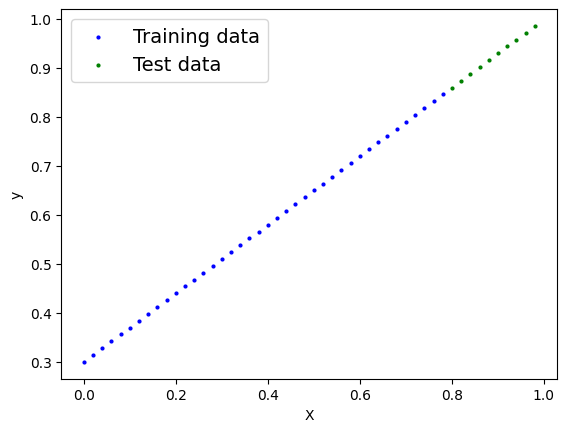

In [ ]:
plot_predictions();

## 2. Build Model

Now that we've got some data, let's build a model to use the blue dots to predict the green dots.

This is where we will need OOP.

### What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values we used to create the data)

### How does it do so?
Through 2 main algorithms:
1. **Gradient descent**: An optimization algorithm that iteratively adjusts the model's parameters to minimize a loss function. In this case, the loss function is the Mean Squared Error (MSE) between the predicted values. (This is why we need requires_grad=True)
2. **Backpropagation**: Compute the gradient of the loss function with respect to the weights and biases using the chain rule.


In [ ]:
# Create a linear regression model class inheriting from nn.Module (the base class for all neural network modules)
class LinearRegressionModel(nn.Module):
    def __init__(self):
        # super will call the __init__ method of the parent class (nn.Module) to ensure that all its functionality is initialized
        super().__init__()
        # Define the weights parameter initialized randomly with requires_grad=True to compute gradients for optimization
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        # Define the bias parameter initialized randomly with requires_grad=True to compute gradients
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Define the forward method which handles the forward pass (computation) of the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply the linear regression formula y = wx + b
        return self.weights * x + self.bias

# The goal is to start with random weights and biases, run it through the forward pass,
# and then update the weights and biases to represent the known parameters (currently 0.7 and 0.3)
# as closely as possible

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

> **Resource:** See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).
